In [16]:
import torch
import numpy as np
from matplotlib import pyplot as plt

torch.__version__

'2.7.1+cpu'

In [17]:
# load data
from torchvision import datasets
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True)
train_images, train_labels = train_dataset.data, train_dataset.targets
test_images, test_labels = test_dataset.data, test_dataset.targets

In [18]:
# total of 10 image classes, labeled 0-9:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [19]:
# the shape of the training set
train_images.shape

torch.Size([60000, 28, 28])

In [20]:
# the shape of the training labels
train_labels.shape

torch.Size([60000])

In [21]:
# display the training labels 
train_labels

tensor([9, 0, 0,  ..., 3, 0, 5])

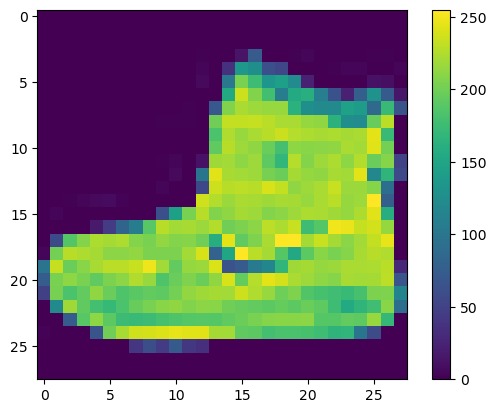

In [22]:
# visualize the first image in the training set, the pixel values are in the range [0, 255]
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [23]:
# normalize the images to the range [0, 1]
train_images = train_images / 255.0

test_images = test_images / 255.0

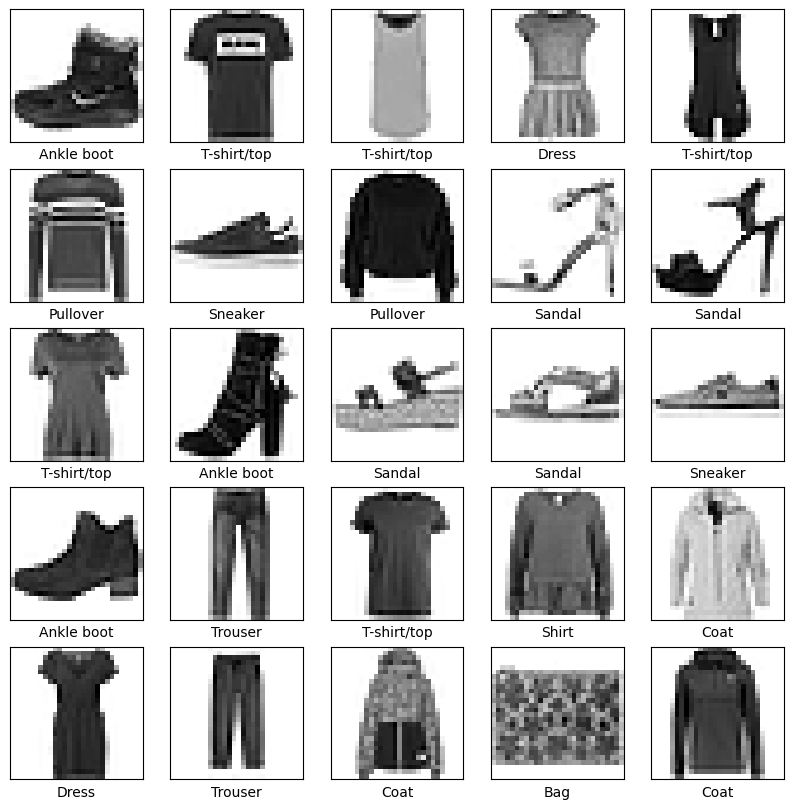

In [24]:
# display the first 25 training images and their labels
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [25]:
# dataloader
from torch.utils.data import TensorDataset, DataLoader
train_tensor_dataset = TensorDataset(train_images, train_labels)
test_tensor_dataset = TensorDataset(test_images, test_labels)
batch_size = 32
train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle=False)

In [26]:
# build a neural network model
# flatten the 2D images into 1D vectors
# the first dense layer with 128 neurons and ReLU activation
# the final layer is a Dense layer that outputs the probability for each class
import torch.nn as nn
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

# instantiate the model    
model = FashionMNISTModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FashionMNISTModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=128, out_features=10, bias=True)
)

In [27]:
import torch.optim as optim
from torchmetrics import Accuracy

# define the optimizer and loss function
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

# define the accuracy metric for multiclass classification
accuracy_metric = Accuracy(task="multiclass", num_classes=10)

In [28]:
# define a function to train the model
def train_epoch(model, dataloader, optimizer, loss_fn, accuracy_metric, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        images = images.float().unsqueeze(1)  # (batch, 1, 28, 28)
        
        optimizer.zero_grad()     #zero the gradients
        outputs = model(images)   # forward pass
        loss = loss_fn(outputs, labels)  # calculate the loss
        loss.backward()           # backward pass
        optimizer.step()          # update the weights
        
        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, dim=1)
        running_acc += accuracy_metric(preds.cpu(), labels.cpu()) * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_acc / len(dataloader.dataset)
    return epoch_loss, epoch_acc


In [29]:
# train the model for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_fn, accuracy_metric, device)
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

Epoch 1/10:
  Train Loss: 0.5108, Train Accuracy: 0.8211
Epoch 2/10:
  Train Loss: 0.3812, Train Accuracy: 0.8626
Epoch 3/10:
  Train Loss: 0.3411, Train Accuracy: 0.8748
Epoch 4/10:
  Train Loss: 0.3157, Train Accuracy: 0.8841
Epoch 5/10:
  Train Loss: 0.3000, Train Accuracy: 0.8894
Epoch 6/10:
  Train Loss: 0.2837, Train Accuracy: 0.8952
Epoch 7/10:
  Train Loss: 0.2717, Train Accuracy: 0.8987
Epoch 8/10:
  Train Loss: 0.2610, Train Accuracy: 0.9022
Epoch 9/10:
  Train Loss: 0.2502, Train Accuracy: 0.9063
Epoch 10/10:
  Train Loss: 0.2440, Train Accuracy: 0.9088


In [30]:
# define a function to test the model
def test(model, dataloader, loss_fn, accuracy_metric, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            images = images.float().unsqueeze(1)
            
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            running_acc += accuracy_metric(preds.cpu(), labels.cpu()) * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_acc / len(dataloader.dataset)
    return epoch_loss, epoch_acc

In [31]:
# test the model
test_loss, test_acc = test(model, test_loader, loss_fn, accuracy_metric, device)
print(f"  Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

  Test Loss: 0.3317, Test Accuracy: 0.8851


In [32]:
# add a softmax layer to convert the outputs into probabilities
probability_model = nn.Sequential(
    model,
    nn.Softmax(dim=1)
)

probability_model.eval()
with torch.no_grad():
    test_input = test_images.to(device)
    test_input = test_input.float().unsqueeze(1)
    predictions = probability_model(test_input) 
    predictions = predictions.cpu().numpy() 


In [33]:
predictions[0]

array([1.9836673e-06, 8.9421794e-09, 3.1153228e-08, 1.4666711e-11,
       2.0140485e-06, 5.8872072e-04, 1.8114003e-08, 1.2993635e-02,
       4.8818549e-07, 9.8641312e-01], dtype=float32)

In [34]:
predicted_class = np.argmax(predictions[0])
predicted_class

np.int64(9)

In [35]:
test_labels[0].item()

9

In [36]:
# visualization
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

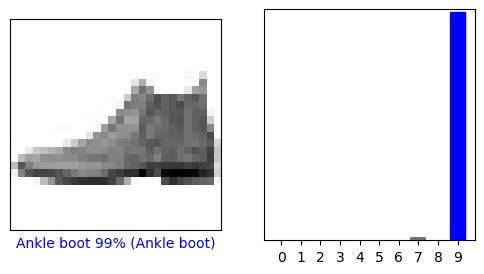

In [37]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

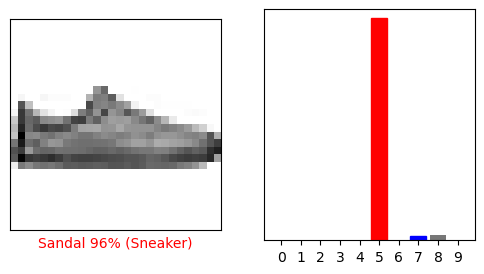

In [38]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

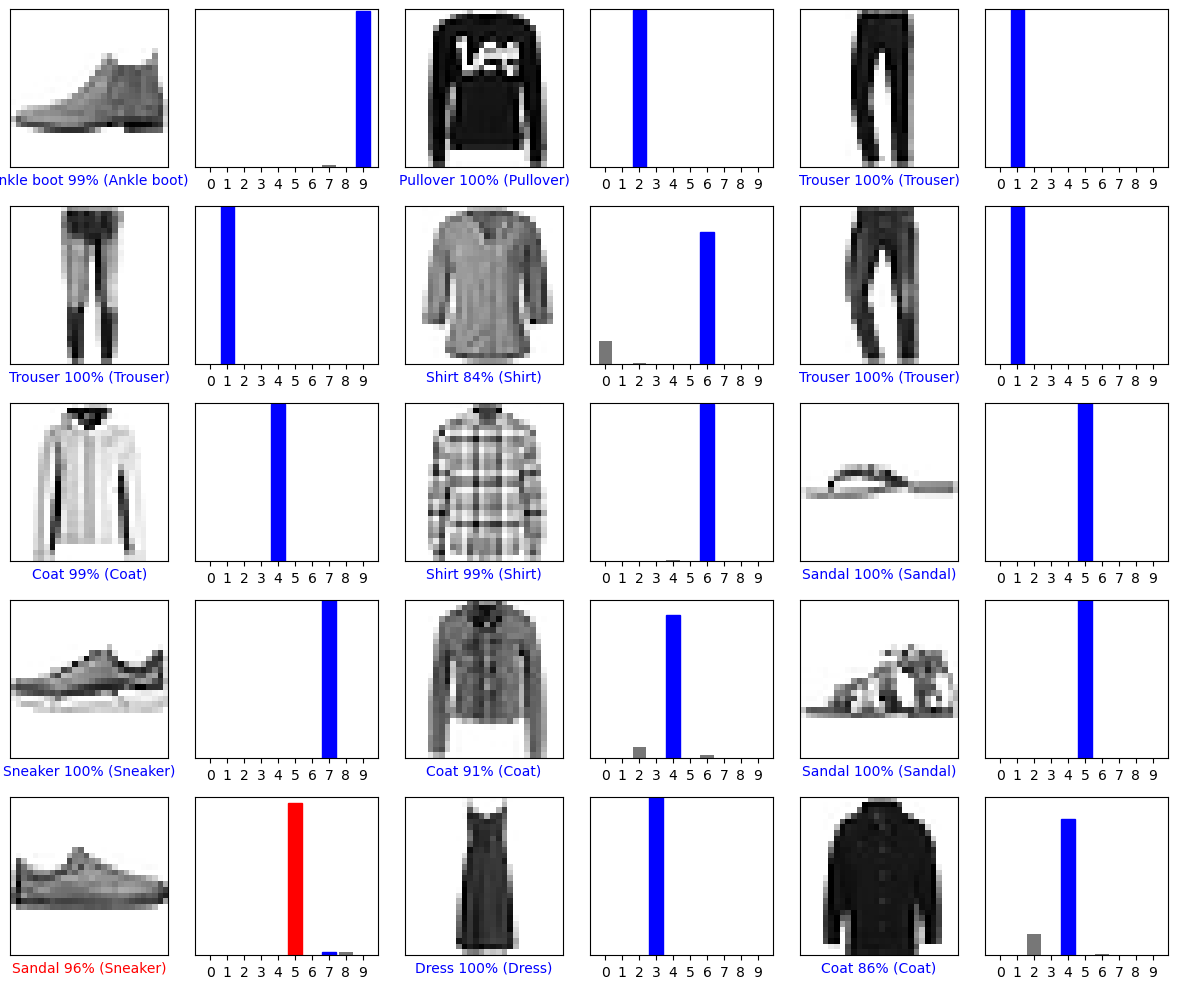

In [39]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()